# Measuring Negative Diction in Latin Satire

Exploratory data analysis based on the following question:
Persius's Satire 1 seems to be especially 'negative' compared to other poems in Latin literature,
even compared to other works of satire. Is Persius 1 more negative than other satires? If so,
how much more negative?

Notes:

- Defining "negative diction" (for now!) as instances of *non*, *nec*, *neque*. Will expand the list on the next pass
- Next steps need to include baseline measures for rates of negative diction in Latin literature in general, Latin poetry and satire specifically

Patrick J. Burns, last updated 11/4/2017

In [1]:
# Imports

import os
import string
import re
import html  

from pprint import pprint

from cltk.corpus.latin import latinlibrary
from cltk.tokenize.word import WordTokenizer
from cltk.tokenize.line import LineTokenizer
from cltk.stem.latin.j_v import JVReplacer

In [2]:
# Setup CLTK tools
word_tokenizer = WordTokenizer('latin')
line_tokenizer = LineTokenizer('latin')
replacer = JVReplacer()

In [3]:
# There appears to be a high concentration of 'negative'
# diction in Persius. Let's quantify this.

# So we get Persius's Satires files from the Latin Library...
files = latinlibrary.fileids()
persius_file = 'persius.txt'
persius_raw = latinlibrary.raw(persius_file)

In [4]:
# Let's separate the Persius LL text by poem

def multifind(match, string):
    """https://stackoverflow.com/a/4664889/1816347"""
    return [s.start() for s in re.finditer(match, string)]

prologue_start = persius_raw.find('PROLOGVS')
satire_starts = multifind(r'\bSATVRA\b', persius_raw)
satire_end = persius_raw.find('The Latin Library \n The Classics Page')

persius_prologue = [persius_raw[prologue_start:satire_starts[0]-1]]

persius_satires = []

for i, start in enumerate(satire_starts):
    if i != len(satire_starts) - 1:
        satire = persius_raw[start:satire_starts[i+1]-1]
    else:
        satire = persius_raw[start:satire_end]
    persius_satires.append(satire)

persius_raws = persius_prologue + persius_satires
print(persius_raws)

["PROLOGVS \n \n\n Nec fonte labra prolui caballino \nnec in bicipiti somniasse Parnaso \nmemini, ut repente sic poeta prodirem. \nHeliconidasque pallidamque Pirenen \nillis remitto quorum imagines lambunt    5 \nhederae sequaces; ipse semipaganus \nad sacra uatum carmen adfero nostrum. \nquis expediuit psittaco suum 'chaere' \npicamque docuit nostra uerba conari? \nmagister artis ingenique largitor    10 \nuenter, negatas artifex sequi uoces. \nquod si dolosi spes refulserit nummi, \ncoruos poetas et poetridas picas \ncantare credas Pegaseium nectar.\n \n\n \n\n \n", 'SATVRA I \n \n\n \nO curas hominum! o quantum est in rebus inane! \n\'quis leget haec?\' min tu istud ais? nemo hercule. \'nemo?\' \nuel duo uel nemo. \'turpe et miserabile.\' quare? \nne mihi Polydamas et Troiades Labeonem \npraetulerint? nugae. non, si quid turbida Roma    5 \neleuet, accedas examenue inprobum in illa \ncastiges trutina nec te quaesiueris extra. \nnam Romae quis non&#151;a, si fas dicere&#151;sed fas \

In [5]:
# Preprocess texts

def preprocess(text):
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
        
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j    
    
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
        
    text = "\n".join([line.strip() for line in text.split('\n')])
    
    return text

In [6]:
# ...get titles...

persius_titles = ["Persius " + line[0].strip().replace('PROLOGVS','Prologue').replace('SATVRA','Satire') for line in [poem.split('\n') for poem in persius_raws]]
print(persius_titles)

['Persius Prologue', 'Persius Satire I', 'Persius Satire II', 'Persius Satire III', 'Persius Satire IV', 'Persius Satire V', 'Persius Satire VI']


In [7]:
# ...preprocess the Satire texts...

persius_edit = [preprocess(raw) for raw in persius_raws]
pprint(persius_edit[0][:500])

('prologus\n'
 'nec fonte labra prolui caballino\n'
 'nec in bicipiti somniasse parnaso\n'
 'memini ut repente sic poeta prodirem\n'
 'heliconidasque pallidamque pirenen\n'
 'illis remitto quorum imagines lambunt\n'
 'hederae sequaces ipse semipaganus\n'
 'ad sacra uatum carmen adfero nostrum\n'
 'quis expediuit psittaco suum chaere\n'
 'picamque docuit nostra uerba conari\n'
 'magister artis ingenique largitor\n'
 'uenter negatas artifex sequi uoces\n'
 'quod si dolosi spes refulserit nummi\n'
 'coruos poetas et poetridas picas\n'
 'cantare credas pegaseium nectar\n')


In [8]:
# ...strip titles...

persius_edit = ["\n".join(poem.split('\n')[1:]) for poem in persius_edit]
pprint(persius_edit[0])

('nec fonte labra prolui caballino\n'
 'nec in bicipiti somniasse parnaso\n'
 'memini ut repente sic poeta prodirem\n'
 'heliconidasque pallidamque pirenen\n'
 'illis remitto quorum imagines lambunt\n'
 'hederae sequaces ipse semipaganus\n'
 'ad sacra uatum carmen adfero nostrum\n'
 'quis expediuit psittaco suum chaere\n'
 'picamque docuit nostra uerba conari\n'
 'magister artis ingenique largitor\n'
 'uenter negatas artifex sequi uoces\n'
 'quod si dolosi spes refulserit nummi\n'
 'coruos poetas et poetridas picas\n'
 'cantare credas pegaseium nectar\n')


In [9]:
persius_tokens = [word_tokenizer.tokenize(tokens) for tokens in persius_edit]
print(persius_tokens[0])

['nec', 'fonte', 'labra', 'prolui', 'caballino', 'nec', 'in', 'bicipiti', 'somniasse', 'parnaso', 'memini', 'ut', 'repente', 'sic', 'poeta', 'prodirem', 'heliconidas', '-que', 'pallidam', '-que', 'pirene', '-ne', 'illis', 'remitto', 'quorum', 'imagines', 'lambunt', 'hederae', 'sequaces', 'ipse', 'semipaganus', 'ad', 'sacra', 'uatum', 'carmen', 'adfero', 'nostrum', 'quis', 'expediuit', 'psittaco', 'suum', 'chaere', 'picam', '-que', 'docuit', 'nostra', 'uerba', 'conari', 'magister', 'artis', 'ingeni', '-que', 'largitor', 'uenter', 'negatas', 'artifex', 'sequi', 'uoces', 'quod', 'si', 'dolosi', 'spes', 'refulserit', 'nummi', 'coruos', 'poetas', 'et', 'poetridas', 'picas', 'cantare', 'credas', 'pegaseium', 'nectar']


In [10]:
negative_words = ['non']
persius_negatives = [{word: tokens.count(word) for word in negative_words} for tokens in persius_tokens]
persius_negatives

[{'non': 0},
 {'non': 15},
 {'non': 5},
 {'non': 11},
 {'non': 5},
 {'non': 12},
 {'non': 1}]

In [11]:
negative_words = ['non', 'nec', 'neque']
persius_negatives = [{word: tokens.count(word) for word in negative_words} for tokens in persius_tokens]
persius_negatives

[{'nec': 2, 'neque': 0, 'non': 0},
 {'nec': 14, 'neque': 2, 'non': 15},
 {'nec': 0, 'neque': 0, 'non': 5},
 {'nec': 1, 'neque': 0, 'non': 11},
 {'nec': 0, 'neque': 0, 'non': 5},
 {'nec': 9, 'neque': 1, 'non': 12},
 {'nec': 2, 'neque': 0, 'non': 1}]

In [12]:
persius_lengths = [len(tokens.split()) for tokens in persius_edit]
persius_lengths

[68, 945, 521, 788, 342, 1288, 570]

In [13]:
persius_negative_totals = [sum(d.values()) for d in persius_negatives]
persius_negative_totals

[2, 31, 5, 12, 5, 22, 3]

In [14]:
persius_negative_relative = [round((1000 * x)/y,2) for x, y in zip(persius_negative_totals, persius_lengths)]
print(persius_negative_relative)

[29.41, 32.8, 9.6, 15.23, 14.62, 17.08, 5.26]


In [15]:
pprint(list(zip(persius_titles, persius_negative_relative)))

[('Persius Prologue', 29.41),
 ('Persius Satire I', 32.8),
 ('Persius Satire II', 9.6),
 ('Persius Satire III', 15.23),
 ('Persius Satire IV', 14.62),
 ('Persius Satire V', 17.08),
 ('Persius Satire VI', 5.26)]


In [16]:
# Do the same for Horace

horace_files = [file for file in files if 'horace/serm' in file]
horace_raw = latinlibrary.raw(horace_files)
pprint(horace_raw[-100:])

("a adflasset, peior serpentibus Afris.'\n"
 ' \n'
 '\n'
 ' \n'
 '\t \n'
 '\t\t Horace \n'
 '\t\t The Latin Library \n'
 '\t\t The Classics Page')


In [17]:
# Let's separate the Persius LL text by poem

satire_starts = multifind(r'\b\d\.\d+\b', horace_raw)
satire_end = horace_raw.find('\t\t Horace \n')

horace_satires = []

for i, start in enumerate(satire_starts):
    if i != len(satire_starts) - 1:
        satire = horace_raw[start:satire_starts[i+1]-1]
    else:
        satire = horace_raw[start:satire_end]
    horace_satires.append(satire)

horace_satires = [satire for satire in horace_satires if satire]
print(horace_satires)

["1.1 \n \n\n \nQui fit, Maecenas, ut nemo, quam sibi sortem \nseu ratio dederit seu fors obiecerit, illa \ncontentus vivat, laudet diversa sequentis? \n'o fortunati mercatores' gravis annis \nmiles ait, multo iam fractus membra labore;    5 \ncontra mercator navim iactantibus Austris: \n'militia est potior. quid enim? concurritur: horae \nmomento cita mors venit aut victoria laeta.' \nagricolam laudat iuris legumque peritus, \nsub galli cantum consultor ubi ostia pulsat;    10 \nille, datis vadibus qui rure extractus in urbem est, \nsolos felicis viventis clamat in urbe. \ncetera de genere hoc&#151;adeo sunt multa&#151;loquacem \ndelassare valent Fabium. ne te morer, audi, \nquo rem deducam. si quis deus 'en ego' dicat    15 \n'iam faciam quod voltis: eris tu, qui modo miles, \nmercator; tu, consultus modo, rusticus: hinc vos, \nvos hinc mutatis discedite partibus. eia, \nquid statis?' nolint. atqui licet esse beatis. \nquid causae est, merito quin illis Iuppiter ambas    20 \niratus 

In [18]:
# ...get titles...

horace_titles = ["Horace Satire " + line[0].strip() for line in [poem.split('\n') for poem in horace_satires]]


horace_edit = [preprocess(raw) for raw in horace_satires] # ...preprocess the Satire texts...
horace_edit = ["\n".join(poem.split('\n')[1:]) for poem in horace_edit] #...strip titles...
horace_tokens = [word_tokenizer.tokenize(tokens) for tokens in horace_edit]

print(horace_tokens[0][:100])

['qui', 'fit', 'maecenas', 'ut', 'nemo', 'quam', 'sibi', 'sortem', 'seu', 'ratio', 'dederit', 'seu', 'fors', 'obiecerit', 'illa', 'contentus', 'uiuat', 'laudet', 'diuersa', 'sequentis', 'o', 'fortunati', 'mercatores', 'grauis', 'annis', 'miles', 'ait', 'multo', 'iam', 'fractus', 'membra', 'labore', 'contra', 'mercator', 'nauim', 'iactantibus', 'austris', 'militia', 'est', 'potior', 'quid', 'enim', 'concurritur', 'horae', 'momento', 'cita', 'mors', 'uenit', 'aut', 'uictoria', 'laeta', 'agricolam', 'laudat', 'iuris', 'legum', '-que', 'peritus', 'sub', 'galli', 'cantum', 'consultor', 'ubi', 'ostia', 'pulsat', 'ille', 'datis', 'uadibus', 'qui', 'rure', 'extractus', 'in', 'urbem', 'est', 'solos', 'felicis', 'uiuentis', 'clamat', 'in', 'urbe', 'cetera', 'de', 'genere', 'hoc', 'adeo', 'sunt', 'multa', 'loquacem', 'delassare', 'ualent', 'fabium', 'ne', 'te', 'morer', 'audi', 'quo', 'rem', 'deducam', 'si', 'quis', 'deus']


In [19]:
negative_words = ['non', 'nec', 'neque']
horace_negatives = [{word: tokens.count(word) for word in negative_words} for tokens in horace_tokens]
horace_negatives

[{'nec': 0, 'neque': 6, 'non': 11},
 {'nec': 5, 'neque': 3, 'non': 9},
 {'nec': 3, 'neque': 1, 'non': 7},
 {'nec': 3, 'neque': 5, 'non': 9},
 {'nec': 1, 'neque': 2, 'non': 5},
 {'nec': 3, 'neque': 3, 'non': 16},
 {'nec': 0, 'neque': 0, 'non': 3},
 {'nec': 1, 'neque': 0, 'non': 2},
 {'nec': 5, 'neque': 1, 'non': 7},
 {'nec': 2, 'neque': 5, 'non': 6},
 {'nec': 2, 'neque': 5, 'non': 3},
 {'nec': 6, 'neque': 2, 'non': 10},
 {'nec': 6, 'neque': 4, 'non': 24},
 {'nec': 2, 'neque': 0, 'non': 9},
 {'nec': 1, 'neque': 1, 'non': 3},
 {'nec': 6, 'neque': 3, 'non': 5},
 {'nec': 0, 'neque': 7, 'non': 12}]

In [20]:
horace_lengths = [len(tokens.split()) for tokens in horace_satires]
horace_negative_totals = [sum(d.values()) for d in horace_negatives]
horace_negative_relative = [round((1000 * x)/y,2) for x, y in zip(horace_negative_totals, horace_lengths)]
print(horace_negative_relative)


[20.02, 17.73, 11.02, 16.98, 11.78, 23.89, 12.88, 9.17, 22.57, 18.57, 16.69, 19.21, 15.0, 17.52, 6.68, 16.79, 23.2]


In [21]:
pprint(list(zip(horace_titles, horace_negative_relative)))
pprint(list(zip(persius_titles, persius_negative_relative)))

[('Horace Satire 1.1', 20.02),
 ('Horace Satire 1.2', 17.73),
 ('Horace Satire 1.3', 11.02),
 ('Horace Satire 1.4', 16.98),
 ('Horace Satire 1.5', 11.78),
 ('Horace Satire 1.6', 23.89),
 ('Horace Satire 1.7', 12.88),
 ('Horace Satire 1.8', 9.17),
 ('Horace Satire 1.9', 22.57),
 ('Horace Satire 1.10', 18.57),
 ('Horace Satire 2.1', 16.69),
 ('Horace Satire 2.2', 19.21),
 ('Horace Satire 2.3', 15.0),
 ('Horace Satire 2.4', 17.52),
 ('Horace Satire 2.5', 6.68),
 ('Horace Satire 2.6', 16.79),
 ('Horace Satire 2.7', 23.2)]
[('Persius Prologue', 29.41),
 ('Persius Satire I', 32.8),
 ('Persius Satire II', 9.6),
 ('Persius Satire III', 15.23),
 ('Persius Satire IV', 14.62),
 ('Persius Satire V', 17.08),
 ('Persius Satire VI', 5.26)]


In [22]:
# Do the same for Juvenal
juvenal_files = [file for file in files if 'juv' in file]
juvenal_raw = latinlibrary.raw(juvenal_files)
pprint(juvenal_raw[-100:])

(" Siculos cantus effugit remige surdo.'\n"
 ' \n'
 ' \n'
 '\t \n'
 '\t\t Juvenal \n'
 '\t\t The Latin Library \n'
 '\t\t The Classics Page')


In [23]:
# Let's separate the Persius LL text by poem

satire_starts = multifind(r'\bD. IVNI IVVENALIS SATVRA\b', juvenal_raw)
satire_end = juvenal_raw.find('\t\t Juvenal \n')

juvenal_satires = []

for i, start in enumerate(satire_starts):
    if i != len(satire_starts) - 1:
        satire = juvenal_raw[start:satire_starts[i+1]-1]
    else:
        satire = juvenal_raw[start:satire_end]
    juvenal_satires.append(satire)

juvenal_satires = [satire for satire in juvenal_satires if satire]

In [24]:
# ...get titles...

juvenal_titles = [line[0].replace('D. IVNI IVVENALIS','Juvenal').replace('SATVRA', 'Satire').strip() for line in [poem.split('\n') for poem in juvenal_satires]]


juvenal_edit = [preprocess(raw) for raw in juvenal_satires] # ...preprocess the Satire texts...
juvenal_edit = ["\n".join(poem.split('\n')[1:]) for poem in juvenal_edit] #...strip titles...
juvenal_tokens = [word_tokenizer.tokenize(tokens) for tokens in juvenal_edit]

print(juvenal_tokens[0][:100])

['semper', 'ego', 'auditor', 'tantum', 'numquamne', 'reponam', 'uexatus', 'totiens', 'rauci', 'theseide', 'cordi', 'inpune', 'ergo', 'mihi', 'recitauerit', 'ille', 'togatas', 'hic', 'elegos', 'inpune', 'diem', 'consumpserit', 'ingens', 'telephus', 'aut', 'summi', 'plena', 'iam', 'margine', 'libri', 'scriptus', 'et', 'in', 'tergo', 'necdum', 'finitus', 'orestes', 'nota', 'magis', 'nulli', 'domus', 'est', 'sua', 'quam', 'mihi', 'lucus', 'martis', 'et', 'aeoliis', 'uicinum', 'rupibus', 'antrum', 'uulcani', 'quid', 'agant', 'uenti', 'quas', 'torqueat', 'umbras', 'aeacus', 'unde', 'alius', 'furtiuae', 'deuehat', 'aurum', 'pelliculae', 'quantas', 'iaculetur', 'monychus', 'ornos', 'frontonis', 'platani', 'conuolsa', '-que', 'marmora', 'clamant', 'semper', 'et', 'adsiduo', 'ruptae', 'lectore', 'columnae', 'expectes', 'eadem', 'a', 'summo', 'minimo', '-que', 'poeta', 'et', 'nos', 'ergo', 'manum', 'ferulae', 'subduximus', 'et', 'nos', 'consilium', 'dedimus', 'sullae']


In [25]:
negative_words = ['non', 'nec', 'neque']
juvenal_negatives = [{word: tokens.count(word) for word in negative_words} for tokens in juvenal_tokens]
juvenal_negatives

juvenal_lengths = [len(tokens.split()) for tokens in juvenal_satires]
juvenal_negative_totals = [sum(d.values()) for d in juvenal_negatives]
juvenal_negative_relative = [round((1000 * x)/y,2) for x, y in zip(juvenal_negative_totals, juvenal_lengths)]
print(juvenal_negative_relative)

[8.77, 10.22, 17.84, 15.2, 22.09, 16.49, 10.34, 14.56, 18.53, 16.76, 8.9, 9.33, 12.82, 11.58, 12.09]


In [26]:
pprint(list(zip(horace_titles, horace_negative_relative)))
pprint(list(zip(persius_titles, persius_negative_relative)))
pprint(list(zip(juvenal_titles, juvenal_negative_relative)))

[('Horace Satire 1.1', 20.02),
 ('Horace Satire 1.2', 17.73),
 ('Horace Satire 1.3', 11.02),
 ('Horace Satire 1.4', 16.98),
 ('Horace Satire 1.5', 11.78),
 ('Horace Satire 1.6', 23.89),
 ('Horace Satire 1.7', 12.88),
 ('Horace Satire 1.8', 9.17),
 ('Horace Satire 1.9', 22.57),
 ('Horace Satire 1.10', 18.57),
 ('Horace Satire 2.1', 16.69),
 ('Horace Satire 2.2', 19.21),
 ('Horace Satire 2.3', 15.0),
 ('Horace Satire 2.4', 17.52),
 ('Horace Satire 2.5', 6.68),
 ('Horace Satire 2.6', 16.79),
 ('Horace Satire 2.7', 23.2)]
[('Persius Prologue', 29.41),
 ('Persius Satire I', 32.8),
 ('Persius Satire II', 9.6),
 ('Persius Satire III', 15.23),
 ('Persius Satire IV', 14.62),
 ('Persius Satire V', 17.08),
 ('Persius Satire VI', 5.26)]
[('Juvenal Satire I', 8.77),
 ('Juvenal Satire X', 10.22),
 ('Juvenal Satire XI', 17.84),
 ('Juvenal Satire XII', 15.2),
 ('Juvenal Satire XIII', 22.09),
 ('Juvenal Satire XIV', 16.49),
 ('Juvenal Satire XV', 10.34),
 ('Juvenal Satire XVI', 14.56),
 ('Juvenal Satir

In [27]:
satire_negative_relative = list(zip(horace_titles, horace_negative_relative)) + \
                            list(zip(persius_titles, persius_negative_relative)) + \
                            list(zip(juvenal_titles, juvenal_negative_relative))


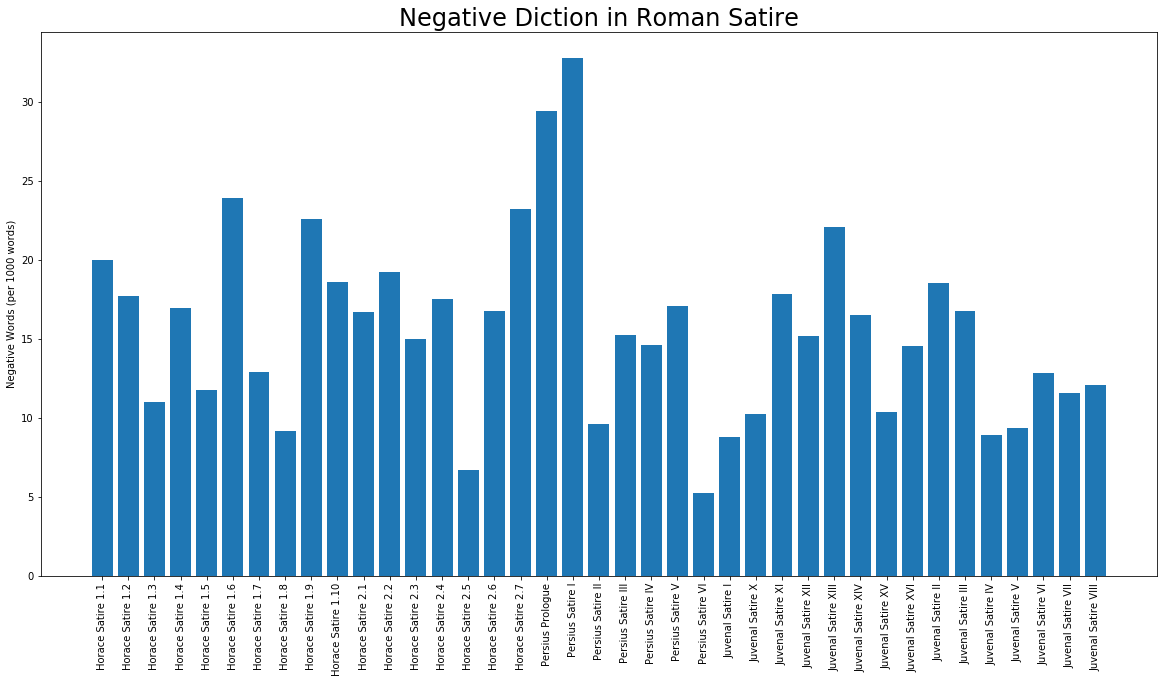

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# sort in-place from highest to lowest
#popularity_data.sort(key=lambda x: x[1], reverse=True) 

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
people = list(zip(*satire_negative_relative))[0]
score = list(zip(*satire_negative_relative))[1]
x_pos = np.arange(len(people)) 

# calculate slope and intercept for the linear trend line
slope, intercept = np.polyfit(x_pos, score, 1)
trendline = intercept + (slope * x_pos)

plt.figure(figsize=(20,10))

plt.title('Negative Diction in Roman Satire', fontsize = 24)
#plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, score,align='center')
plt.xticks(x_pos, people,rotation='vertical') 
plt.ylabel('Negative Words (per 1000 words)')
plt.show()